# 1D Wave Equation Modeling Using PINNs (Constant Velocity Medium)
The goal of this notebook is to use a Physics-Informed Neural Net (PINN) to predict the seismic wavefield generated by some (given) initial conditions in a 1D acoustic isotropic medium with **constant velocity**. The main difference in this example is that the **velocity model is also an input of the neural net**.

## Outline
- We create a neural net $N$ which takes into input the position $x$, the time $t$, and **the velocity** profile $v$ (assumed constant). The output is the acoustic pressure $p(x,t)$ at this location/time: 

$$N: \; x,t,v \mapsto p(x,t,v)$$

- We train the neural net with velocities ranging from 1 km/s to 1.5 km/s. After training, the inference is done for velocities ranging from 1 km/s to 2 km/s 
- We start with some initial conditions and we enforce a boundary condition on the 1D modeling domain: 
    1. Two initial conditions on the pressure field itself and on its time derivative
    $$ p(x,t=0) = sin(x) $$ and $$\frac{\partial p(x,t)}{\partial t}|_{t=0} = sin(x),$$ for all $x \in [0, L]$, where $L$ is the length of the domain.   
    2. One boundary condition 
    $$p(x,t) = 0,$$ for all $t$ and $x\in \{0,L\}$.
    3. One constraint enforcing the pressure field to satisfy the wave-equation inside the 1D modeling domain:
        $$\frac{1}{v(x)^2}\frac{\partial^2 p(x,t)}{\partial t^2} - \frac{\partial^2 p(x,t)}{\partial x^2} = 0,$$ for all $x \in [0,L]$ and $t \in [0, 2L].$ 
- For the training stage of the PINN, we add these four constraints
- In this notebook, we compare the **PINN solution** with the numercial solution obtained using a **finite-difference (FD)** scheme 

## Finite-difference solution

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
################## Modeling parameters ##################
L = float(np.pi)
x = np.arange(0, L, 0.04)
t = np.arange(0, 2*L, 0.04)
vel = np.arange(1, 2, 0.2)
nx = x.shape[0]
nt = t.shape[0]
nvel = vel.shape[0]
X, T, Vel = np.meshgrid(x, t, vel)

In [3]:
################## FD solution ##################
# Sampling
dx = 0.01
dt = 0.001

# Boundaries
L = float(np.pi)
x0 = 0
x1 = np.pi
t0 = 0
t1 = 2*np.pi
fmax = 1.0/(2*np.pi)
s = dt*dt/(dx*dx)

# Generate 1D mesh
x_fd = np.arange(x0, x1, dx)
t_fd = np.arange(t0, t1, dt)
v_fd = np.arange(1, 2, 0.2)
nx_fd = x_fd.shape[0]
nt_fd = t_fd.shape[0]
nv_fd = v_fd.shape[0] 

# FD stability/dispersion
courant = v_fd.max()*dt/dx
disp = v_fd.min()/(dt*fmax)
print("Courant:" , courant)
print("Dispersion:" , disp)

## Finite-difference solution
u_fd = np.zeros((nv_fd, nt_fd, nx_fd))

# Initial conditions
u_fd[:,0,:] = np.sin(x_fd)
u_fd[:,1,:] = np.sin(x_fd)*(dt+1)     
    
# FD scheme 
for it in range(2,nt_fd,1):
    u_fd[:,it,2:nx_fd-1] = 2*(1-s*v_fd[:,2:nx_fd-1]*v_fd[:,2:nx_fd-1])*u_fd[:,it-1,2:nx_fd-1] - u_fd[:,it-2,2:nx_fd-1] + s*v_fd[:,2:nx_fd-1]*v_fd[:,2:nx_fd-1]*(u_fd[:,it-1,3:nx_fd]+u_fd[:,it-1,1:nx_fd-2]) 
  
            
# Subsample FD solution
u_fd_sub = u_fd[:,0::40,0::4]
x_fd_sub = x_fd[0::4]
t_fd_sub = t_fd[0::40]

Courant: 0.18
Dispersion: 6283.185307179586


## PINN solution
Modify the file ``problem.py`` and train the PINN for **velocities ranging from 1 to 1.5 km/s**. Then, load the solution and compare the predicted pressure wavefield with the finite-difference solution

In [4]:
import training.stage1.infer as infer_stage1

# Display information on inferencer
infer_stage1.info

# Predicted solutions
u1 = infer_stage1.infer(x=X, t=T, vel=Vel)['u']
u1 = u1.reshape(X.shape)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


velocity:  1.4


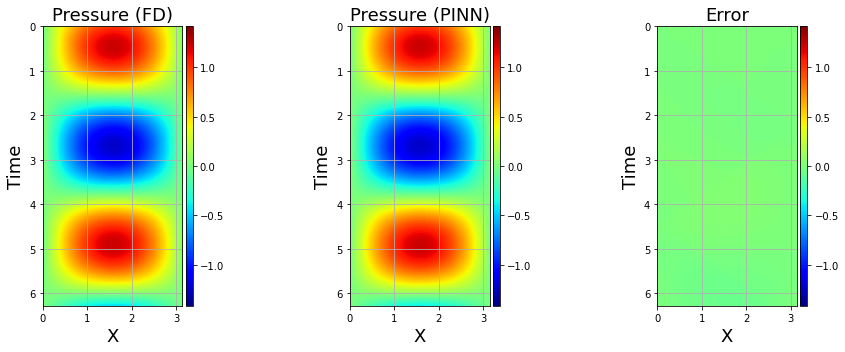

In [5]:
################## Plotting with velocity inside the training interval ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Select velocity
ivel = 2
print("velocity: ", v_fd[ivel])

# FD solution
img0 = axs[0].imshow(u_fd_sub[ivel,:,:], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Time', fontsize=18)
axs[0].set_title('Pressure (FD)', fontsize=18)
axs[0].grid()
plt.tight_layout()

# PINN 1 solution
img1 = axs[1].imshow(u1[:,:,ivel], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img1, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Time', fontsize=18)
axs[1].set_title('Pressure (PINN)', fontsize=18)
axs[1].grid()
plt.tight_layout()

# Error
img4 = axs[2].imshow(u_fd_sub[ivel,:,:]-u1[:,:,ivel], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img4, cax=cax)
axs[2].set_xlabel('X', fontsize=18)
axs[2].set_ylabel('Time', fontsize=18)
axs[2].set_title('Error', fontsize=18)
axs[2].grid()
plt.tight_layout()

# Save figure
plt.savefig("we-fwd-1d-vel-training-pressure.png")


velocity:  1.7999999999999998


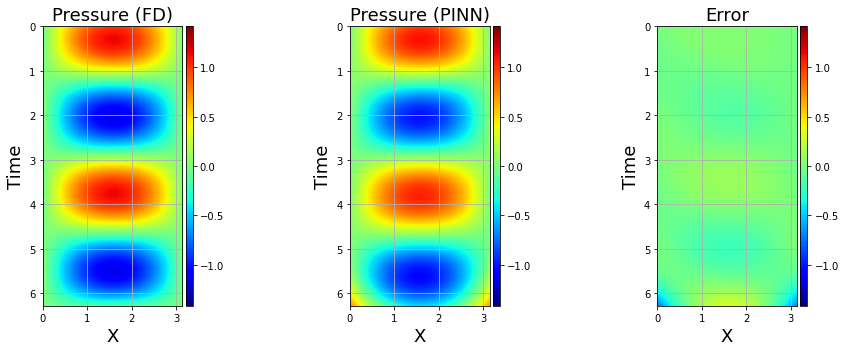

In [6]:
################## Plotting with velocity **NOT** used for training ##################
# This is just a test done out of curiosity - In general, we should not extrapolate
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Select velocity
ivel = 4
print("velocity: ", v_fd[ivel]) # Inference for v=1.8 km/s

# FD solution
img0 = axs[0].imshow(u_fd_sub[ivel,:,:], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Time', fontsize=18)
axs[0].set_title('Pressure (FD)', fontsize=18)
axs[0].grid()
plt.tight_layout()

# PINN 1 solution
img1 = axs[1].imshow(u1[:,:,ivel], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img1, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Time', fontsize=18)
axs[1].set_title('Pressure (PINN)', fontsize=18)
axs[1].grid()
plt.tight_layout()

# Error
img4 = axs[2].imshow(u_fd_sub[ivel,:,:]-u1[:,:,ivel], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img4, cax=cax)
axs[2].set_xlabel('X', fontsize=18)
axs[2].set_ylabel('Time', fontsize=18)
axs[2].set_title('Error', fontsize=18)
axs[2].grid()
plt.tight_layout()

# Save figure
plt.savefig("we-fwd-1d-vel-not-training-pressure.png")

FD time:  0.02
PINN time:  0.8


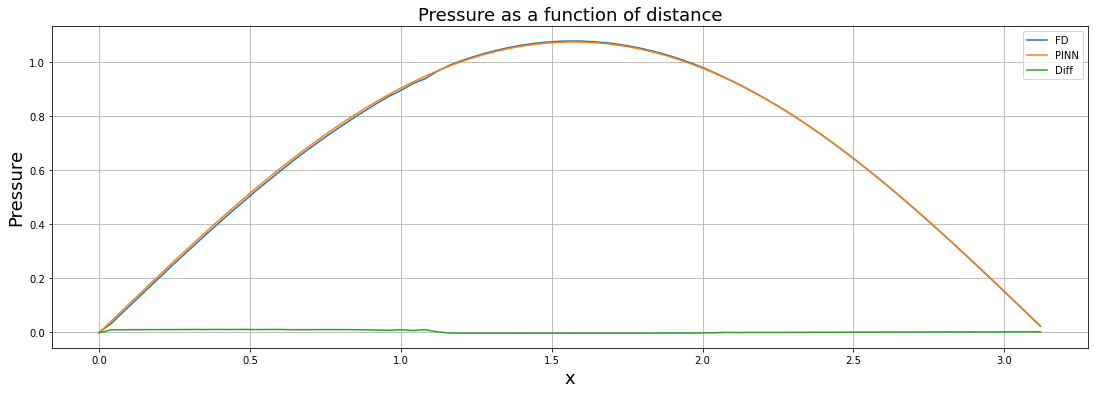

In [7]:
####### 1D plots: Pressure at constant time #######
ivel = 2 # Velocity value
itime = 20 # Time 

print("FD time: ", t_fd[itime])
print("PINN time: ", t[itime])

p_fd = u_fd_sub[ivel,itime,:] # FD solution
p1 = u1[itime,:,ivel]

################## Plotting ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# FD solution
img0 = axs.plot(x_fd_sub, p_fd, label="FD")
img0 = axs.plot(x, p1, label="PINN")
img0 = axs.plot(x, p1-p_fd, label="Diff")
plt.tight_layout()
axs.grid()
axs.set_xlabel('x', fontsize=18)
axs.set_ylabel('Pressure', fontsize=18)
axs.set_title('Pressure as a function of distance', fontsize=18)
axs.legend()

# Save figure
plt.savefig("we-fwd-1d-vel-pressure-vs-distance.png")

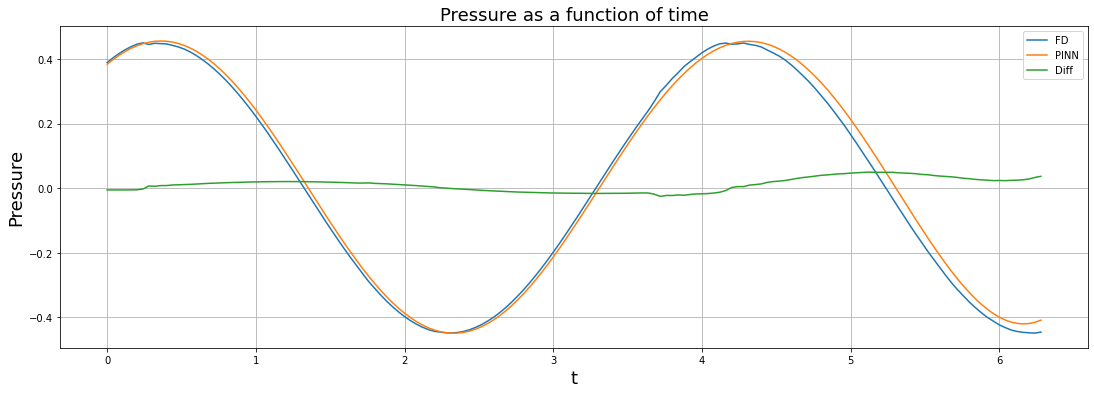

In [8]:
####### 1D plots at constant x-position #######
ivel = 3 # Velocity value
ipos = 10 # x-position 

p_fd = u_fd_sub[ivel,:,ipos] # FD solution
p1 = u1[:,ipos,ivel]

################## Plotting ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# Solutions
img0 = axs.plot(t_fd_sub, p_fd, label="FD")
img0 = axs.plot(t, p1, label="PINN")
img0 = axs.plot(t, p1-p_fd, label="Diff")
plt.tight_layout()
axs.grid()
axs.set_xlabel('t', fontsize=18)
axs.set_ylabel('Pressure', fontsize=18)
axs.set_title('Pressure as a function of time', fontsize=18)
axs.legend()

# Save figure
plt.savefig("we-fwd-1d-vel-pressure-vs-time.png")